Begun 5/14/24

NB 15 showed that having no noise in the reference map causes E-->B leakage to become important. This notebook will generate power law noise from a prototype reference map and see if the issues with leakage go away.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

from scipy.optimize import curve_fit
def power_law(x,a,b):
    return a*np.power(x,b)

In [2]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2, depth1_mask

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [3]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def sample_likelihood_and_max(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # I don't expect there to be issues with multiple max values
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def sample_null_eb_likelihood_and_max(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [4]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [5]:
# Loading in depth-1 map, calculating power spectra with filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90 # Do we want to turn off filtering here? Not now - want it to be realistic to what we will have
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2, depth1_mask = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


In [6]:
# Fitting power law to TT, EE, BB to everything after the first five points (35 for TT)
depth1_TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=depth1_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
depth1_EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_EE[5:], p0=[0,0],bounds=(-np.inf,np.inf))
depth1_BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_BB[5:], p0=[0,0],bounds=(-np.inf,np.inf))

In [7]:
depth1_noise_TT = np.zeros(arr_len)
depth1_noise_EE = np.zeros(arr_len)
depth1_noise_BB = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
depth1_noise_TT[90:2501] = power_law(np.arange(90,2501), *depth1_TT_fit)
depth1_noise_EE[90:2501] = power_law(np.arange(90,2501), *depth1_EE_fit)
depth1_noise_BB[90:2501] = power_law(np.arange(90,2501), *depth1_BB_fit)

In [8]:
# Loading in reference map, cutting it to same size as depth-1 map, and calculating spectra to get noise
ref_path = "/home/zbh5/act_analysis/dr6_analysis/act_daynight_f150_map.fits"

ref_maps = enmap.read_map(ref_path)
ref_maps = enmap.extract(ref_maps,depth1_mask.shape,depth1_mask.wcs)

ref_TEB = enmap.map2harm(ref_maps*depth1_mask, normalize = "phys")

if unpixwin:  # remove pixel window in Fourier space
    for i in range(len(ref_maps)):
        wy, wx = enmap.calc_window(ref_maps[i].shape)
        ref_TEB[i] /= wy[:, np.newaxis]
        ref_TEB[i] /= wx[np.newaxis, :]
ly, lx = ref_TEB.lmap()
kfilter_x = np.abs(lx) >= kx_cut
kfilter_y = np.abs(ly) >= ky_cut
filtered_ref_TEB = ref_TEB * kfilter_x * kfilter_y

ref_T = filtered_ref_TEB[0]
ref_E = filtered_ref_TEB[1]
ref_B = filtered_ref_TEB[2]

# Doing filtering and binning as normal
_, ref_TT, _ = spectrum_from_maps(ref_T,ref_T,1.0,w2,lmax,bin_size)
_, ref_EE, _ = spectrum_from_maps(ref_E,ref_E,1.0,w2,lmax,bin_size)
_, ref_BB, _ = spectrum_from_maps(ref_B,ref_B,1.0,w2,lmax,bin_size)

In [9]:
# Fitting power law to TT, EE, BB to everything after the first ten points (35 for TT)
ref_TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=ref_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
ref_EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[10:], ydata=ref_EE[10:], p0=[0,0],bounds=(-np.inf,np.inf))
ref_BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[10:], ydata=ref_BB[10:], p0=[0,0],bounds=(-np.inf,np.inf))

[ 1.65715584e+10 -4.11850562e+00]


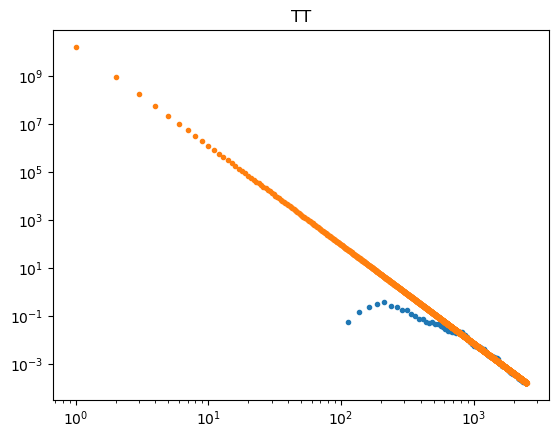

[ 0.48430254 -1.18491069]


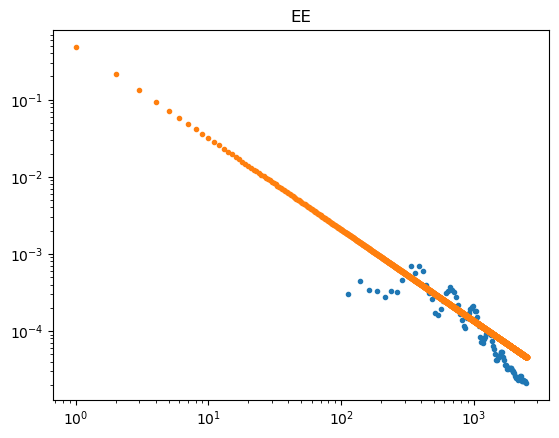

[ 0.08981932 -1.17814855]


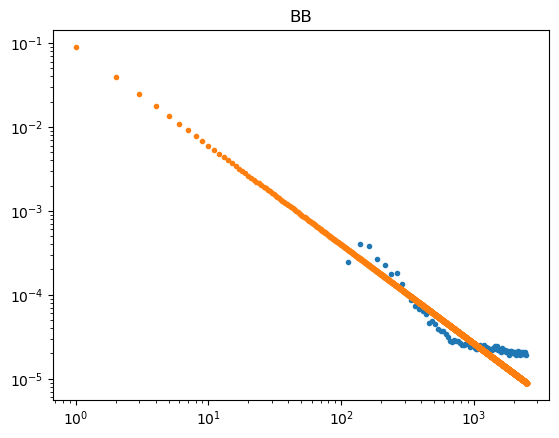

In [10]:
# Checking fits
print(ref_TT_fit)
plt.loglog(ell_b, ref_TT, marker=".", ls="none",label = "TT")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *ref_TT_fit), marker=".", ls="none",label = "fit")
plt.title('TT')
plt.show()
plt.close()
print(ref_EE_fit)
plt.loglog(ell_b, ref_EE, marker=".", ls="none",label = "EE")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *ref_EE_fit), marker=".", ls="none",label = "fit")
plt.title('EE')
plt.show()
plt.close()
print(ref_BB_fit)
plt.loglog(ell_b, ref_BB, marker=".", ls="none",label = "BB")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *ref_BB_fit), marker=".", ls="none",label = "fit")
plt.title('BB')
plt.show()
plt.close()

In [11]:
ref_noise_TT = np.zeros(arr_len)
ref_noise_EE = np.zeros(arr_len)
ref_noise_BB = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
ref_noise_TT[90:2501] = power_law(np.arange(90,2501), *ref_TT_fit)
ref_noise_EE[90:2501] = power_law(np.arange(90,2501), *ref_EE_fit)
ref_noise_BB[90:2501] = power_law(np.arange(90,2501), *ref_BB_fit)

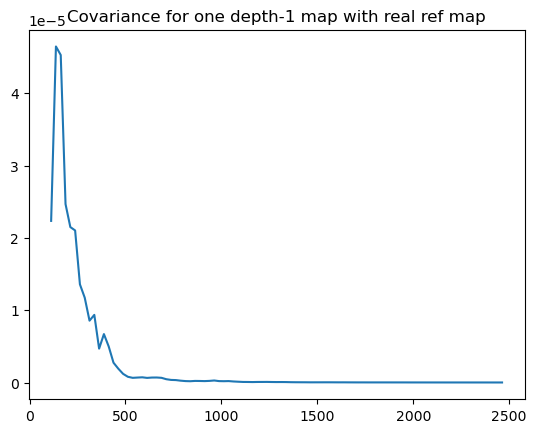

In [12]:
# Out of interest, generating a realistic covariance for our estimator from the existing maps.
# We want to see if it has similar structure to the simulated one to assess whether we might be able
# to get Gaussian errorbars from real maps even if we can't from the simulated ones where the noise
# isn't handled quite right.

_, ClEB_cross12, _ = spectrum_from_maps(depth1_E,ref_B,1.0,w2,lmax,bin_size)
_, ClEB_cross21, _ = spectrum_from_maps(ref_E,depth1_B,1.0,w2,lmax,bin_size)
_, ClEE_cross12, _ = spectrum_from_maps(depth1_E,ref_E,1.0,w2,lmax,bin_size)
_, ClBB_cross12, _ = spectrum_from_maps(depth1_B,ref_B,1.0,w2,lmax,bin_size)
_, ClEB_rot, _ = spectrum_from_maps(depth1_E,depth1_B,1.0,w2,lmax,bin_size)
_, ClEB_unrot, _ = spectrum_from_maps(ref_E,ref_B,1.0,w2,lmax,bin_size)

# Adding back in prefactor because of cut sky for these spectra
binned_nu = bincount*w2
covariance = (1/binned_nu)*((depth1_EE*ref_BB+ClEB_cross12**2) \
              + (ref_EE*depth1_BB+ClEB_cross21**2) \
              - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
              
plt.plot(ell_b[4:],covariance[4:])
plt.title("Covariance for one depth-1 map with real ref map")
plt.show()
plt.close()

In [30]:
print(binned_nu)

[   7.38794764   25.52200094   41.64115942   60.44684433   75.2227396
   94.02842451  110.14758299  128.95326789  139.69937355  162.53484807
  178.65400656  194.77316505  209.54906033  233.72779806  241.1157457
  268.65264145  278.0554839   298.204432    308.95053766  335.81580181
  342.53211784  366.71085557  382.83001406  394.91938292  416.41159424
  432.53075273  445.9633848   468.79885932  482.903123    499.69391309
  517.15633478  534.61875648  545.36486213  568.20033666  588.34928477
  593.05070599  616.55781212  636.70676023  654.16918192  663.57202437
  697.15360455  691.78055172  723.34723709  738.79476397  758.94371208
  772.37634416  791.18202906  803.27139792  815.36076679  843.56929414
  854.3153998   874.4643479   887.89697998  912.07571771  912.07571771
  952.37361392  947.6721927   979.23887807  992.67151014 1008.79066863
 1015.50698466 1057.14814409 1051.77509126 1074.61056578 1097.4460403
 1098.78930351 1128.34109407 1147.14677897 1164.60920067 1164.60920067
 1200.205

In [13]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

6.870972823634812
RA crossing 0


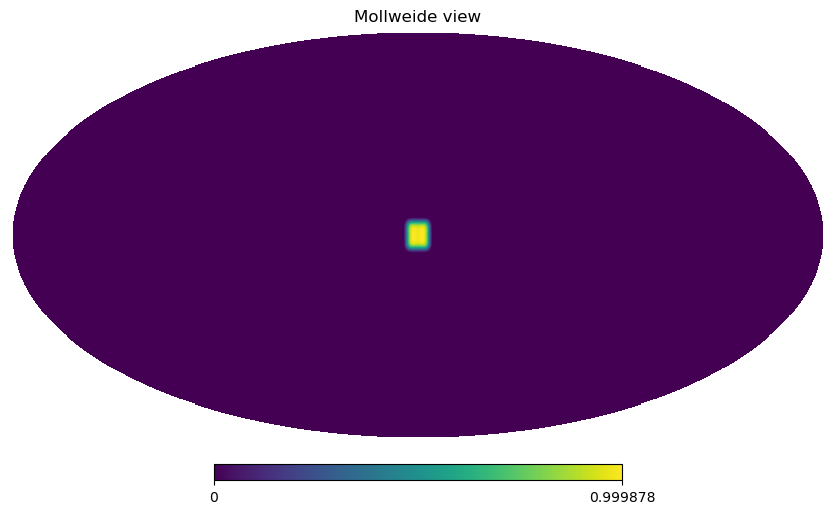

In [14]:
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))
# Example mask
ra = [-5,5]
dec = [5,-5]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [15]:
# Doing 500 sims of full sky maps plus noise both rotated and unrotated maps (from depth-1 and ref, respectively)
# with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Back to doing 500 sims all at 1 deg rotation to get uncertainty on recovering a fixed angle
# Adding above mask to unrotated and rotated maps
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    rot_noise_maps = hp.sphtfunc.synfast((depth1_noise_TT, np.zeros(depth1_noise_TT.size), 
                                          depth1_noise_EE, depth1_noise_BB),nside)
    np.random.seed(noise_seeds[i]+1)
    unrot_noise_maps = hp.sphtfunc.synfast((ref_noise_TT, np.zeros(ref_noise_TT.size), 
                                            ref_noise_EE, ref_noise_BB),nside)
    # Adding noise to signal and ref maps
    rot_sim_maps_masked = m_sm*(rot_sim_maps + rot_noise_maps)
    unrot_sim_maps_masked = m_sm*(unrot_sim_maps + unrot_noise_maps)
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps_masked[1], rot_sim_maps_masked[2], unrot_sim_maps_masked[1], unrot_sim_maps_masked[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps_masked, map2=rot_sim_maps_masked)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps_masked)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps_masked, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true? Ask Steve
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range back to being centered at zero for the random distribution of angles
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=10000)

    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:34:33<00:00, 18.55s/it]


Median of full sky angles, our estimator: 0.8704087040870423
Mean of full sky angles, our estimator: 0.3260568605686061
Std dev of full sky angles, our estimator: 17.695854528501375


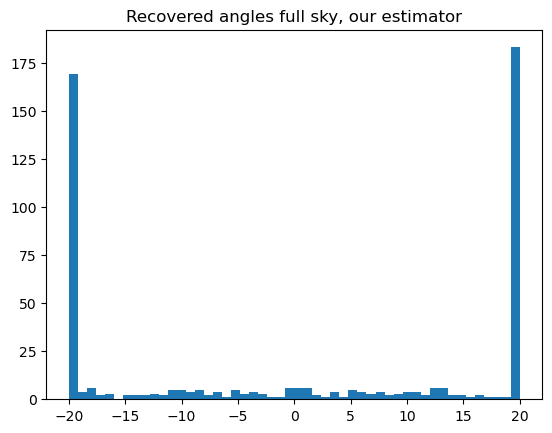

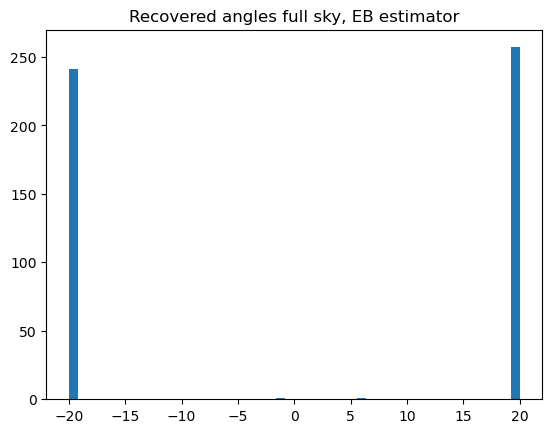

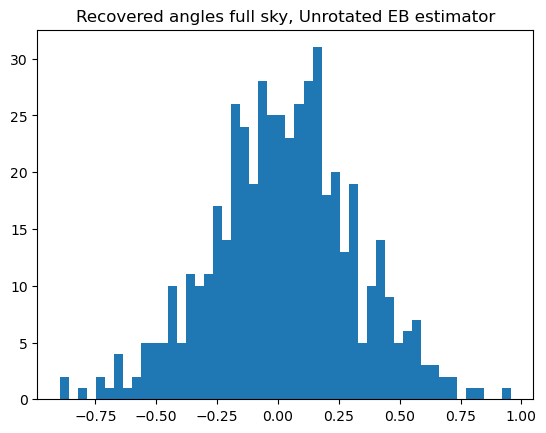

Median of full sky angles, map based estimator: -1.800860753890278
Mean of full sky angles, map based estimator: -0.8584406721322914
Std dev of full sky angles, map based estimator: 25.817756097849607


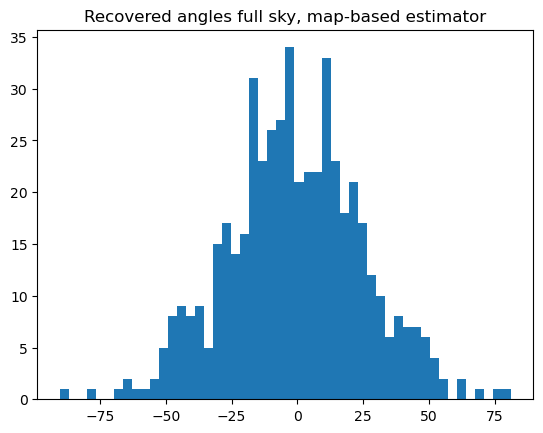

In [16]:
output_mapspace_angles = np.array(output_mapspace_angles)

# Plotting the angles by themselves instead of percent difference
print("Median of full sky angles, our estimator: " + str(np.median(output_angles_only)))
print("Mean of full sky angles, our estimator: " + str(np.mean(output_angles_only)))
print("Std dev of full sky angles, our estimator: " + str(np.std(output_angles_only)))
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
print("Median of full sky angles, map based estimator: " + str(np.median(output_mapspace_angles)))
print("Mean of full sky angles, map based estimator: " + str(np.mean(output_mapspace_angles)))
print("Std dev of full sky angles, map based estimator: " + str(np.std(output_mapspace_angles)))
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

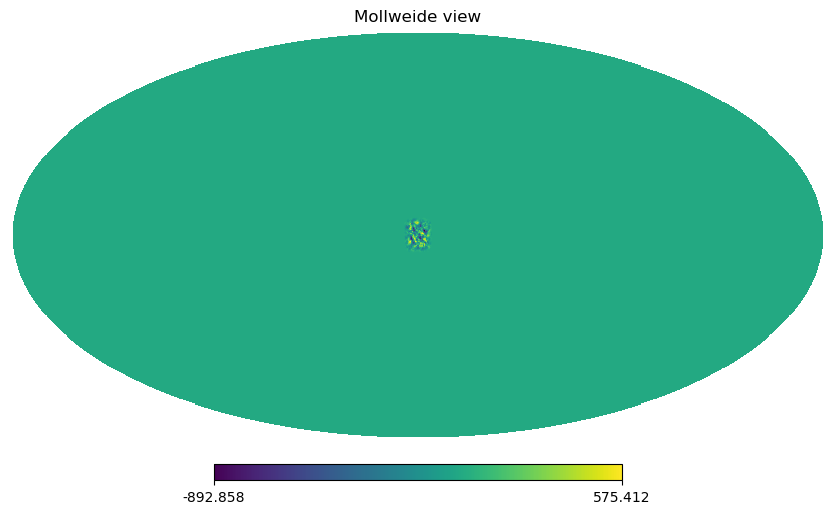

In [36]:
hp.mollview(unrot_sim_maps_masked[0])

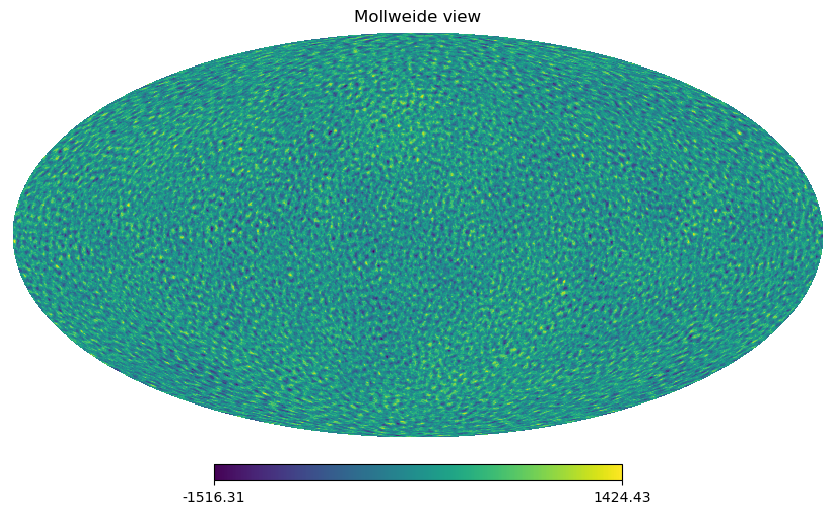

In [40]:
hp.mollview((unrot_sim_maps[0]+unrot_noise_maps[0]))

In [22]:
output_spectra = np.array(output_spectra)

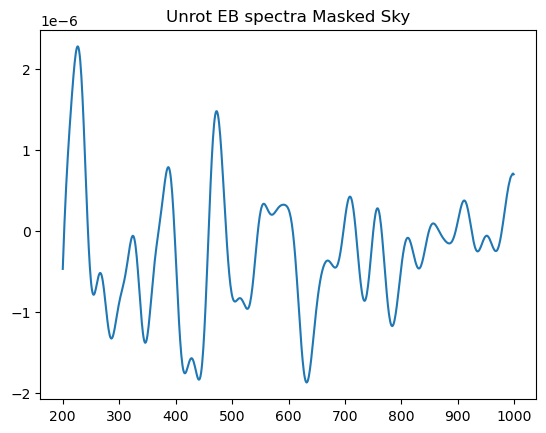

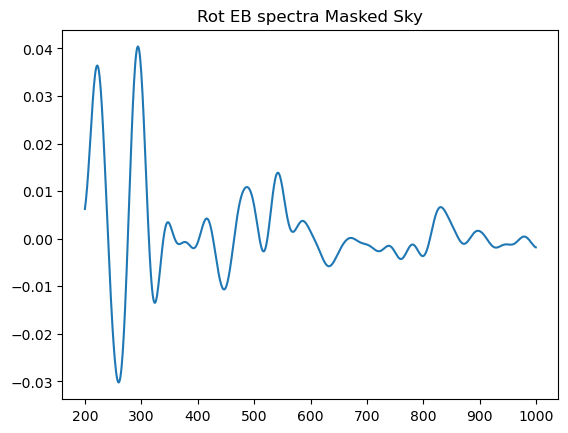

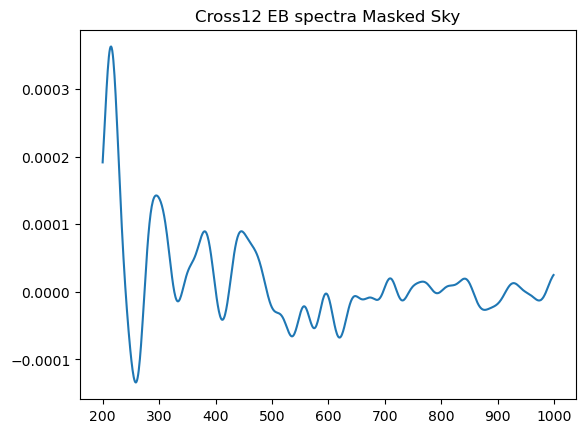

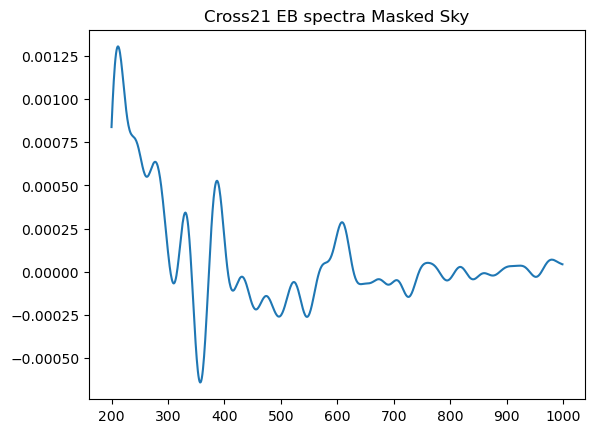

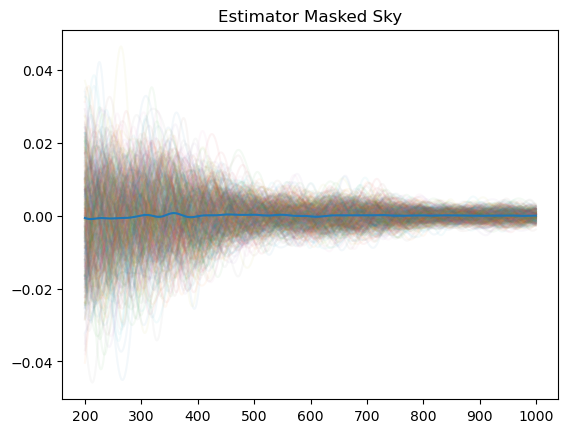

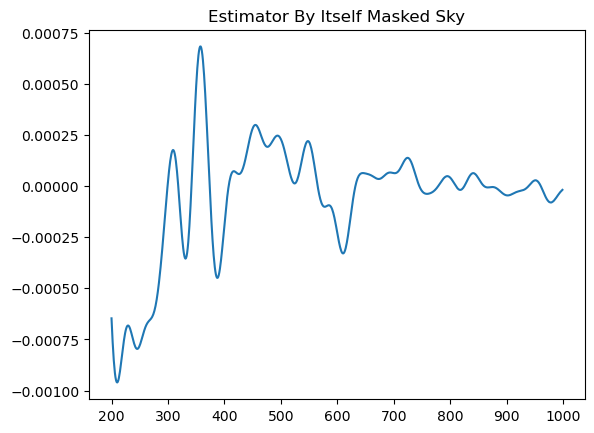

In [31]:
# Plotting all of the EB spectra
mean_EB = np.mean(output_spectra[:,10],axis=0)
mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)
mean_estimator = np.mean(output_spectra[:,16] - output_spectra[:,22], axis=0)

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][10],alpha=0.05)
plt.title("Unrot EB spectra Masked Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][4],alpha=0.05)
plt.title("Rot EB spectra Masked Sky")
plt.plot(ell_hp,mean_EB_rot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][16],alpha=0.05)
plt.title("Cross12 EB spectra Masked Sky")
plt.plot(ell_hp,mean_EB_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][22],alpha=0.05)
plt.title("Cross21 EB spectra Masked Sky")
plt.plot(ell_hp,mean_EB_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][16]-output_spectra[i][22],alpha=0.05)
plt.title("Estimator Masked Sky")
plt.plot(ell_hp,mean_estimator)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

plt.title("Estimator By Itself Masked Sky")
plt.plot(ell_hp,mean_estimator)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

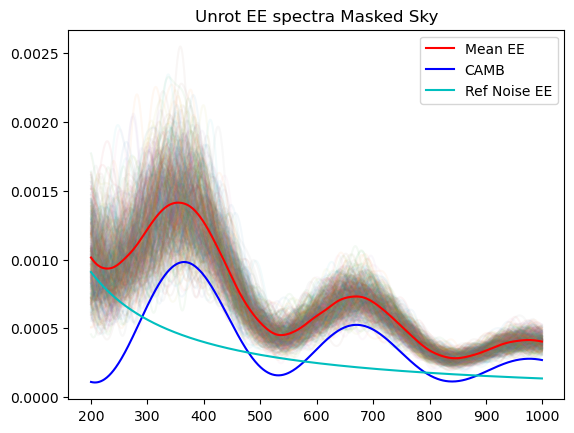

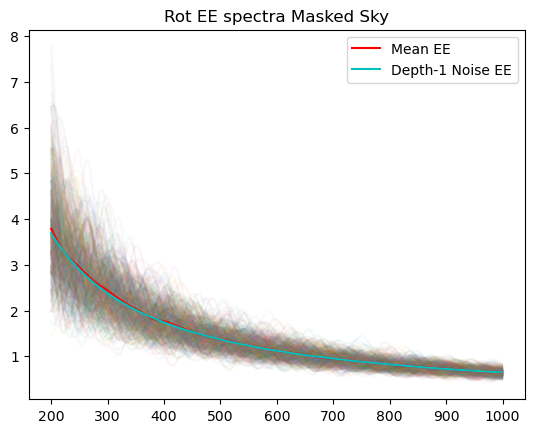

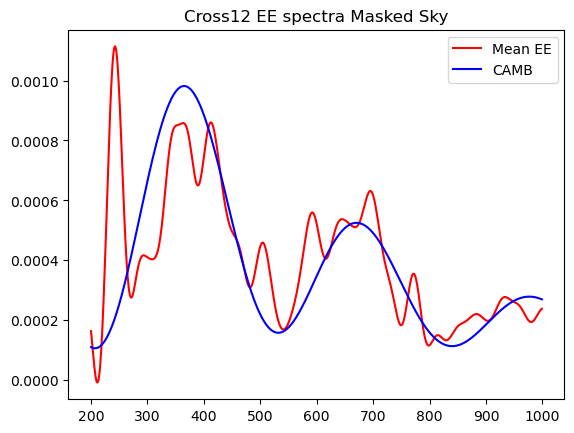

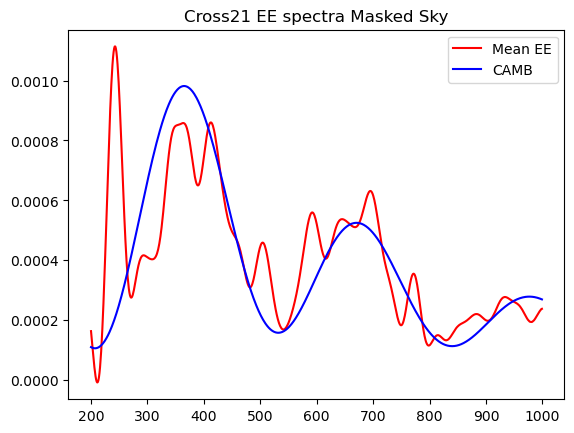

In [33]:
# Plotting all of the EE spectra
mean_EE = np.mean(output_spectra[:,7],axis=0)
mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
mean_EE_cross21 = np.mean(output_spectra[:,19],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][7],alpha=0.05)
plt.title("Unrot EE spectra Masked Sky")
plt.plot(ell_hp,mean_EE,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
plt.plot(ell[min_ell:max_ell],ref_noise_EE[min_ell:max_ell],'c',label='Ref Noise EE')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][1],alpha=0.05)
plt.title("Rot EE spectra Masked Sky")
plt.plot(ell_hp,mean_EE_rot,'r',label='Mean EE')
#plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
plt.plot(ell[min_ell:max_ell],depth1_noise_EE[min_ell:max_ell],'c',label='Depth-1 Noise EE')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][13],alpha=0.05)
plt.title("Cross12 EE spectra Masked Sky")
plt.plot(ell_hp,mean_EE_cross12,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][19],alpha=0.05)
plt.title("Cross21 EE spectra Masked Sky")
plt.plot(ell_hp,mean_EE_cross21,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

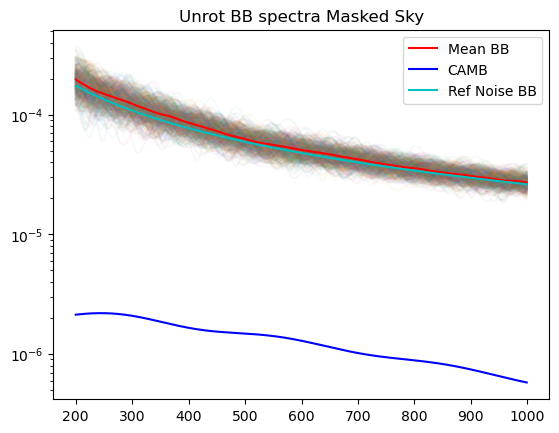

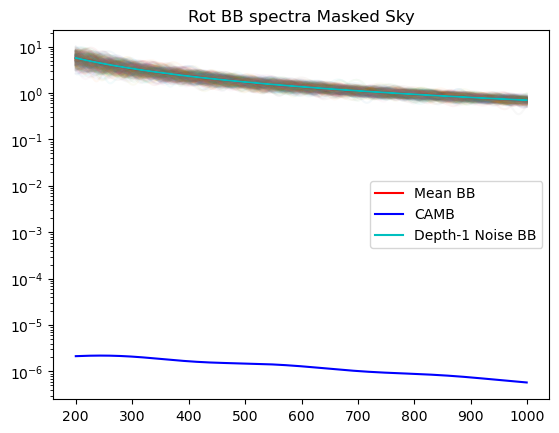

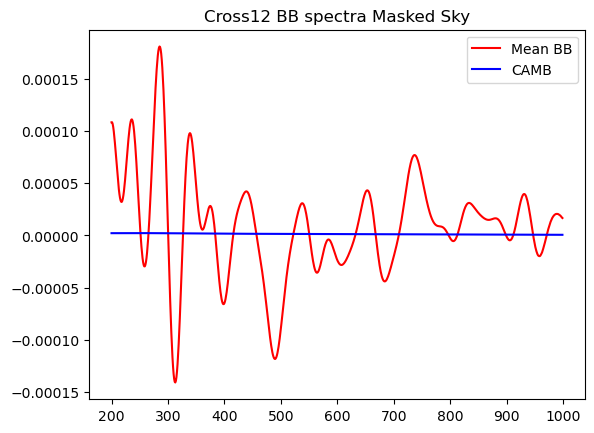

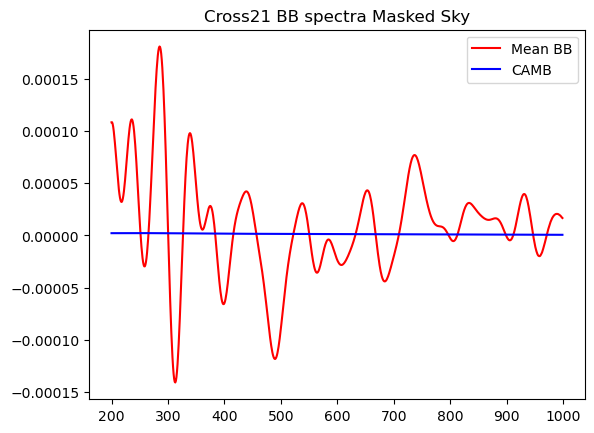

In [34]:
# Plotting all of the BB spectra
mean_BB = np.mean(output_spectra[:,8],axis=0)
mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)
mean_BB_cross21 = np.mean(output_spectra[:,20],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][8],alpha=0.05)
plt.title("Unrot BB spectra Masked Sky")
plt.semilogy(ell_hp,mean_BB,'r',label='Mean BB')
plt.semilogy(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
plt.semilogy(ell[min_ell:max_ell],ref_noise_BB[min_ell:max_ell],'c',label='Ref Noise BB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][2],alpha=0.05)
plt.title("Rot BB spectra Masked Sky")
plt.semilogy(ell_hp,mean_BB_rot,'r',label='Mean BB')
plt.semilogy(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
plt.semilogy(ell[min_ell:max_ell],depth1_noise_BB[min_ell:max_ell],'c',label='Depth-1 Noise BB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][14],alpha=0.05)
plt.title("Cross12 BB spectra Masked Sky")
plt.plot(ell_hp,mean_BB_cross12,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra)):
#    plt.plot(ell_hp,output_spectra[i][20],alpha=0.05)
plt.title("Cross21 BB spectra Masked Sky")
plt.plot(ell_hp,mean_BB_cross21,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()